In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import classification_models
from classification_models import GetLoader

In [2]:
#导入train数据
a=np.load("train_data.npy")
b=a.reshape([a.shape[0],a.shape[1]*a.shape[2]])
c=b[~np.isnan(b).any(axis=1),:]
train_data=c.reshape([c.shape[0], a.shape[1],a.shape[2]])
d=np.load("train_label.npy").reshape(-1,1)
train_label=d[~np.isnan(b).any(axis=1),:].reshape(-1,)

In [3]:
#导入valid数据
a=np.load("valid_data.npy")
b=a.reshape([a.shape[0],a.shape[1]*a.shape[2]])
c=b[~np.isnan(b).any(axis=1),:]
valid_data=c.reshape([c.shape[0], a.shape[1],a.shape[2]])
d=np.load("valid_label.npy").reshape(-1,1)
valid_label=d[~np.isnan(b).any(axis=1),:].reshape(-1,)

In [4]:
train_data=np.transpose(train_data,(0,2,1))
valid_data=np.transpose(valid_data,(0,2,1))

In [5]:
def predict_precision(model,images,labels,device,predict_type):
    model.eval()
    with torch.no_grad():
        correct=0
        total=0
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=sum(predicted)
        correct+=(sum(predicted*labels))
        print('precision of the model on the'+predict_type+'data: {}%'.format(100*correct/total))
    model.train()
    return predicted, 100*correct/total

In [ ]:
# 搭建CONV1D-LSTM Model (Many-to-One)
class CONV1D_LSTM(nn.Module):
    def __init__(self ,in_channel,out_channel, hidden_size, num_layers, num_classes,device=torch.device("cuda:1")):
        super(CONV1D_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(in_channels=in_channel, out_channels=out_channel,kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channel)
        self.conv2 = nn.Conv1d(in_channels=out_channel, out_channels=out_channel,kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channel)
        self.relu = nn.LeakyReLU()
        self.lstm = nn.LSTM(out_channel, hidden_size, num_layers, batch_first=True)  # batch_first=True仅仅针对输入而言
        self.fc = nn.Linear(hidden_size, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight.to(device), mode='fan_out', nonlinearity='relu')
                   
    def forward(self, x):
        
        #forward prop
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out=torch.transpose(out,2,1)
        #因为pytorch里lstm和conv1d的input sequence位置不一样，需要调整。
        
        # 设置初始状态h_0与c_0的状态是初始的状态，一般设置为0，尺寸是,x.size(0)
        h0 = Variable(torch.zeros(self.num_layers, out.size(0), self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers, out.size(0), self.hidden_size)).to(device)

        # Forward propagate RNN
        out, (h_n, c_n) = self.lstm(out, (h0, c0))  # 送入一个初始的x值，作为输入以及(h0, c0)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])  # output也是batch_first, 实际上h_n与c_n并不是batch_first
        return out

In [ ]:
#Conv1DLSTM trial 1
# Hyper Parameters
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
in_channel = 42
out_channel=32
hidden_size = 64  # 隐藏层的size
num_layers =  3 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 700
learning_rate = 0.001

device = torch.device("cuda:1")

In [8]:
train=GetLoader(train_data,train_label)
valid=GetLoader(valid_data,valid_label)
train_loader=torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=0)
valid_loader=torch.utils.data.DataLoader(dataset=valid,batch_size=valid_data.shape[0],shuffle=False,num_workers=0)

In [ ]:
conv1d_lstm = CONV1D_LSTM(in_channel=in_channel, out_channel=out_channel,
                   hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
conv1d_lstm.to(device)

In [ ]:
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(conv1d_lstm.parameters(), lr=learning_rate)

In [ ]:
total_step=0
train_precision=[]
valid_precision=[]

In [ ]:
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=conv1d_lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%1000==0:
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(conv1d_lstm,images,labels,device,predict_type='training')
            train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(conv1d_lstm,images,labels,device,predict_type='validation')
            valid_precision.append(valid_pre)

In [ ]:
plt.plot(train_precision,label="training precision")
plt.plot(valid_precision,label="validation precision")
plt.title("conv1d_lstm on stock")
plt.xlabel("1000*x training step")
plt.ylabel("precision")

In [ ]:
#Conv1D_LSTM trial 1 总结:
#batch_size，learning_rate等参数全部继承LSTM实验中筛选出的最优参数
#整体效果并不好，在44000-55000step中可以稳定保证valid precision在0.53-0.54间，之后由于过拟合 valid precision整体下降
#吸取LSTM实验中的教训，目前没有找到特别好的方法减小过拟合
#故下一步试验改变网络结构，将LSTM的hidden_layer缩小到一层进一步尝试

In [ ]:
#Conv1DLSTM trial 2
# Hyper Parameters
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
in_channel = 42
out_channel=32
hidden_size = 64  # 隐藏层的size
num_layers =  1 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 700
learning_rate = 0.001

device = torch.device("cuda:1")

In [ ]:
conv1d_lstm = CONV1D_LSTM(in_channel=in_channel, out_channel=out_channel,
                   hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
conv1d_lstm.to(device)

In [ ]:
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(conv1d_lstm.parameters(), lr=learning_rate)

In [ ]:
total_step=0
train_precision=[]
valid_precision=[]

In [ ]:
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=conv1d_lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%1000==0:
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(conv1d_lstm,images,labels,device,predict_type='training')
            train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(conv1d_lstm,images,labels,device,predict_type='validation')
            valid_precision.append(valid_pre)

In [ ]:
plt.plot(train_precision,label="training precision")
plt.plot(valid_precision,label="validation precision")
plt.title("conv1d_lstm on stock")
plt.xlabel("1000*x training step")
plt.ylabel("precision")

In [ ]:
#Conv1D_LSTM trial 2 总结:在将LSTM缩减为一层后模型在valid数据集的表现下降了一个档次，没有任何一段可以稳定超过0.53
#由于LSTM hidden layer是唯一变量，而再将其减小后模型表现变差了，故怀疑是LSTM的比重减小是原因
#下一步试验将LSTM hidden layer增加为2再尝试

In [ ]:
#Conv1DLSTM trial 3
# Hyper Parameters
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
in_channel = 42
out_channel=32
hidden_size = 64  # 隐藏层的size
num_layers =  2 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 1000
learning_rate = 0.001

device = torch.device("cuda:1")

In [ ]:
conv1d_lstm = CONV1D_LSTM(in_channel=in_channel, out_channel=out_channel,
                   hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
conv1d_lstm.to(device)

In [ ]:
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(conv1d_lstm.parameters(), lr=learning_rate)

In [ ]:
total_step=0
train_precision=[]
valid_precision=[]

In [ ]:
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=conv1d_lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%1000==0:
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(conv1d_lstm,images,labels,device,predict_type='training')
            train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(conv1d_lstm,images,labels,device,predict_type='validation')
            valid_precision.append(valid_pre)

In [ ]:
plt.plot(train_precision,label="training precision")
plt.plot(valid_precision,label="validation precision")
plt.title("conv1d_lstm on stock")
plt.xlabel("1000*x training step")
plt.ylabel("precision")

In [ ]:
#Conv1D_LSTM trial 3 总结：没有太大改观
#经过思考，决定下一步尝试取消batch_norm进行尝试（normalization消除了conv产生的数据间距）

In [6]:
#Conv1D_LSTM trial 4
# 搭建CONV1D-LSTM Model (Many-to-One) without batch_norm
class CONV1D_LSTM(nn.Module):
    def __init__(self ,in_channel,out_channel, hidden_size, num_layers, num_classes,device=torch.device("cuda:1")):
        super(CONV1D_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(in_channels=in_channel, out_channels=out_channel,kernel_size=1, stride=1, bias=False)
        #self.bn1 = nn.BatchNorm1d(out_channel)
        self.conv2 = nn.Conv1d(in_channels=out_channel, out_channels=out_channel,kernel_size=1, stride=1, bias=False)
        #self.bn2 = nn.BatchNorm1d(out_channel)
        self.relu = nn.LeakyReLU()
        self.lstm = nn.LSTM(out_channel, hidden_size, num_layers, batch_first=True)  # batch_first=True仅仅针对输入而言
        self.fc = nn.Linear(hidden_size, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight.to(device), mode='fan_out', nonlinearity='relu')
                   
    def forward(self, x):
        
        #forward prop
        out = self.conv1(x)
        #out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        #out = self.bn2(out)
        out = self.relu(out)
        
        out=torch.transpose(out,2,1)
        #因为pytorch里lstm和conv1d的input sequence位置不一样，需要调整。
        
        # 设置初始状态h_0与c_0的状态是初始的状态，一般设置为0，尺寸是,x.size(0)
        h0 = Variable(torch.zeros(self.num_layers, out.size(0), self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers, out.size(0), self.hidden_size)).to(device)

        # Forward propagate RNN
        out, (h_n, c_n) = self.lstm(out, (h0, c0))  # 送入一个初始的x值，作为输入以及(h0, c0)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])  # output也是batch_first, 实际上h_n与c_n并不是batch_first
        return out

In [ ]:
#LSTM non-BN trial
for i in range(2,7):
    # Hyper Parameters
    sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
    in_channel = 42
    out_channel=32
    hidden_size = 64  # 隐藏层的size
    num_layers =  2 # 有多少层

    num_classes = 2
    batch_size = 256
    num_epochs = 800
    learning_rate = 0.001

    device = torch.device("cuda:1")
    
    conv1d_lstm = CONV1D_LSTM(in_channel=in_channel, out_channel=out_channel,
                               hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
    conv1d_lstm.to(device)
    
    # Loss and Optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(conv1d_lstm.parameters(), lr=learning_rate)
    
    total_step=0
    train_precision=[]
    valid_precision=[]
    
    #训练过程
    for epoch in range(num_epochs):
        for data in train_loader:
            images, labels = data
            images=images.type(torch.FloatTensor)
            labels=labels.type(torch.FloatTensor)
            images=images.to(device)
            labels=labels.to(device)
            #forward pass
            outputs=conv1d_lstm(images)
            loss=loss_function(outputs,labels.long())
        
            #Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_step+=1
            if (total_step)%1000==0:#each 10 iterations is one epoch
                print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
                _,train_pre=predict_precision(conv1d_lstm,images,labels,device,predict_type='training')
                train_precision.append(train_pre)
                for images, labels in valid_loader:
                    _,valid_pre=predict_precision(conv1d_lstm,images,labels,device,predict_type='validation')
                valid_precision.append(valid_pre)
            
    #plot
    plt.plot(train_precision,label="training precision")
    plt.plot(valid_precision,label="validation precision")
    plt.title("conv1d_lstm NonBN trial hidden layer::"+str(i))
    plt.xlabel("1000*x training step")
    plt.ylabel("precision")
    plt.show()

In [ ]:
#Conv1D_LSTM trial 4 总结：最高的validation precision明显有所提高，但是往往都在训练epoch较小时，所以对模型的真实性有所怀疑
#下一步试验，不训练模型直接测试和用极少epoch测试效果

In [21]:
#Conv1D_LSTM trial 5 不训练就测试
#选择hidden layer为5的模型做测试
    # Hyper Parameters
    sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
    in_channel = 42
    out_channel=32
    hidden_size = 64  # 隐藏层的size
    num_layers =  2 # 有多少层

    num_classes = 2
    batch_size = 256
    num_epochs = 100
    learning_rate = 0.001

    device = torch.device("cuda:1")
    

In [16]:
arb=[]
for i in range(50):
    conv1d_lstm = CONV1D_LSTM(in_channel=in_channel, out_channel=out_channel,
                               hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
    conv1d_lstm.to(device)
    
    # Loss and Optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(conv1d_lstm.parameters(), lr=learning_rate)
    #不训练直接测试
    for images, labels in valid_loader:
        _,valid_pre=predict_precision(conv1d_lstm,images,labels,device,predict_type='validation')
        arb.append(valid_pre)

precision of the model on thevalidationdata: 51.38856887817383%
precision of the model on thevalidationdata: 51.06849670410156%
precision of the model on thevalidationdata: 51.11299514770508%
precision of the model on thevalidationdata: 51.98850631713867%
precision of the model on thevalidationdata: 0.0%
precision of the model on thevalidationdata: 51.09861755371094%
precision of the model on thevalidationdata: 51.05290222167969%
precision of the model on thevalidationdata: 51.1104850769043%
precision of the model on thevalidationdata: nan%
precision of the model on thevalidationdata: 51.1104850769043%
precision of the model on thevalidationdata: 51.10703659057617%
precision of the model on thevalidationdata: nan%
precision of the model on thevalidationdata: 55.26315689086914%
precision of the model on thevalidationdata: 64.60674285888672%
precision of the model on thevalidationdata: nan%
precision of the model on thevalidationdata: 51.1104850769043%
precision of the model on thevalida

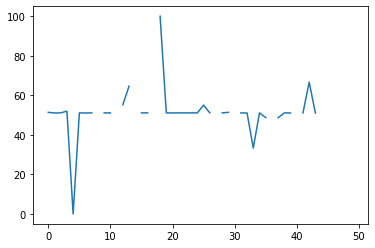

In [17]:
plt.plot(arb)

In [ ]:
#Conv1D_LSTM trial 5 总结: 不训练就测试效果十分随机。
#接下来利用极少的训练次数进行训练。

In [44]:
    train_precision={}
    valid_precision={}

In [45]:
#Conv1D_LSTM trial 6 
for i in range(10):    
    #num_epoch调小为50进行测试
    total_step=0
    train_precision[str(i)]=[]
    valid_precision[str(i)]=[]
    conv1d_lstm = CONV1D_LSTM(in_channel=in_channel, out_channel=out_channel,
                               hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
    conv1d_lstm.to(device)
    
    # Loss and Optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(conv1d_lstm.parameters(), lr=learning_rate)
    #训练过程
    for epoch in range(num_epochs):
        for data in train_loader:
            images, labels = data
            images=images.type(torch.FloatTensor)
            labels=labels.type(torch.FloatTensor)
            images=images.to(device)
            labels=labels.to(device)
            #forward pass
            outputs=conv1d_lstm(images)
            loss=loss_function(outputs,labels.long())
        
            #Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_step+=1
            if (total_step)%1000==0:#each 10 iterations is one epoch
                print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
                _,train_pre=predict_precision(conv1d_lstm,images,labels,device,predict_type='training')
                train_precision[str(i)].append(train_pre)
                for images, labels in valid_loader:
                    _,valid_pre=predict_precision(conv1d_lstm,images,labels,device,predict_type='validation')
                valid_precision[str(i)].append(valid_pre)
            

Epoch [6/100],step[1000] Loss:0.6369
precision of the model on thetrainingdata: 60.41666793823242%
precision of the model on thevalidationdata: 58.93290328979492%
Epoch [12/100],step[2000] Loss:0.6022
precision of the model on thetrainingdata: 65.4676284790039%
precision of the model on thevalidationdata: 56.1988525390625%
Epoch [18/100],step[3000] Loss:0.6104
precision of the model on thetrainingdata: 65.89147186279297%
precision of the model on thevalidationdata: 55.532955169677734%
Epoch [24/100],step[4000] Loss:0.5618
precision of the model on thetrainingdata: 70.09346008300781%
precision of the model on thevalidationdata: 57.13924026489258%
Epoch [30/100],step[5000] Loss:0.5073
precision of the model on thetrainingdata: 79.61164855957031%
precision of the model on thevalidationdata: 54.10591125488281%
Epoch [36/100],step[6000] Loss:0.4978
precision of the model on thetrainingdata: 62.79069900512695%
precision of the model on thevalidationdata: 53.91376495361328%
Epoch [42/100],ste

Epoch [18/100],step[3000] Loss:0.5963
precision of the model on thetrainingdata: 61.11111068725586%
precision of the model on thevalidationdata: 54.15559768676758%
Epoch [24/100],step[4000] Loss:0.5646
precision of the model on thetrainingdata: 65.0%
precision of the model on thevalidationdata: 56.25129318237305%
Epoch [30/100],step[5000] Loss:0.5584
precision of the model on thetrainingdata: 70.87378692626953%
precision of the model on thevalidationdata: 55.489418029785156%
Epoch [36/100],step[6000] Loss:0.5580
precision of the model on thetrainingdata: 68.54838562011719%
precision of the model on thevalidationdata: 55.03641891479492%
Epoch [42/100],step[7000] Loss:0.5447
precision of the model on thetrainingdata: 73.78640747070312%
precision of the model on thevalidationdata: 54.02802276611328%
Epoch [48/100],step[8000] Loss:0.4370
precision of the model on thetrainingdata: 85.07462310791016%
precision of the model on thevalidationdata: 55.63887405395508%
Epoch [54/100],step[9000] Lo

Epoch [30/100],step[5000] Loss:0.5800
precision of the model on thetrainingdata: 72.04301452636719%
precision of the model on thevalidationdata: 53.51411056518555%
Epoch [36/100],step[6000] Loss:0.5239
precision of the model on thetrainingdata: 68.99224853515625%
precision of the model on thevalidationdata: 50.55940246582031%
Epoch [42/100],step[7000] Loss:0.4208
precision of the model on thetrainingdata: 85.96491241455078%
precision of the model on thevalidationdata: 53.188899993896484%
Epoch [48/100],step[8000] Loss:0.3899
precision of the model on thetrainingdata: 83.03571319580078%
precision of the model on thevalidationdata: 52.115264892578125%
Epoch [54/100],step[9000] Loss:0.2803
precision of the model on thetrainingdata: 87.1212158203125%
precision of the model on thevalidationdata: 51.89495086669922%
Epoch [60/100],step[10000] Loss:0.3209
precision of the model on thetrainingdata: 84.21052551269531%
precision of the model on thevalidationdata: 50.7833366394043%
Epoch [66/100],

precision of the model on thevalidationdata: 50.8890266418457%
Epoch [48/100],step[8000] Loss:0.4672
precision of the model on thetrainingdata: 82.60869598388672%
precision of the model on thevalidationdata: 53.31406784057617%
Epoch [54/100],step[9000] Loss:0.3516
precision of the model on thetrainingdata: 82.35294342041016%
precision of the model on thevalidationdata: 52.27535629272461%
Epoch [60/100],step[10000] Loss:0.2918
precision of the model on thetrainingdata: 87.82608795166016%
precision of the model on thevalidationdata: 52.12642288208008%
Epoch [66/100],step[11000] Loss:0.2720
precision of the model on thetrainingdata: 86.5079345703125%
precision of the model on thevalidationdata: 53.458457946777344%
Epoch [72/100],step[12000] Loss:0.2449
precision of the model on thetrainingdata: 87.82608795166016%
precision of the model on thevalidationdata: 54.05854415893555%
Epoch [78/100],step[13000] Loss:0.2200
precision of the model on thetrainingdata: 89.43089294433594%
precision of 

Text(0, 0.5, 'precision')

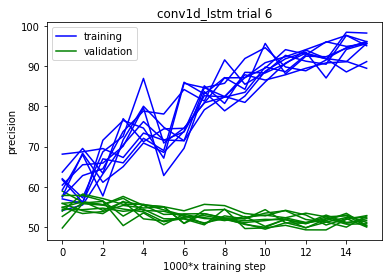

In [54]:
for i in range(10):    
    plt.plot(train_precision[str(i)],c='blue')
    plt.plot(valid_precision[str(i)],c='green')

plt.legend(["training","validation"])
plt.title("conv1d_lstm trial 6")
plt.xlabel("1000*x training step")
plt.ylabel("precision")

In [55]:
#Conv1D_LSTM trial 5 总结: 在使用Conv1D_LSTM时用较小的epoch可以达到比较好的效果，并且的确是由训练得出的
#下一步试验：验证LSTM和Conv1D_LSTM之间的模型的信号相关性

In [66]:
#Conv1D_LSTM trial 6：测试和LSTM模型之间的信号相关性，进一步验证conv1d的意义
from classification_models import LSTM
#LSTM trial 1
#Hyper Parameters
sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
input_size = 42  # 输入数据的维度
hidden_size = 64  # 隐藏层的size
num_layers =  4 # 有多少层

num_classes = 2
batch_size = 256
num_epochs = 500
learning_rate = 0.001

device = torch.device("cuda:1")

lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
lstm.to(device)

LSTM(
  (lstm): LSTM(42, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [67]:
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [58]:
train_data=np.transpose(train_data,(0,2,1))
valid_data=np.transpose(valid_data,(0,2,1))

In [59]:
train=GetLoader(train_data,train_label)
valid=GetLoader(valid_data,valid_label)
train_loader=torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=0)
valid_loader=torch.utils.data.DataLoader(dataset=valid,batch_size=valid_data.shape[0],shuffle=False,num_workers=0)

In [68]:
total_step=0
lstm_train_precision=[]
lstm_valid_precision=[]

In [69]:
#训练过程
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%1000==0:#each 10 iterations is one epoch
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(lstm,images,labels,device,predict_type='training')
            lstm_train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(lstm,images,labels,device,predict_type='validation')
            lstm_valid_precision.append(valid_pre)

Epoch [6/500],step[1000] Loss:0.5960
precision of the model on thetrainingdata: 62.931034088134766%
precision of the model on thevalidationdata: 53.86490249633789%
Epoch [12/500],step[2000] Loss:0.5721
precision of the model on thetrainingdata: 65.27777862548828%
precision of the model on thevalidationdata: 52.987422943115234%
Epoch [18/500],step[3000] Loss:0.5352
precision of the model on thetrainingdata: 77.39130401611328%
precision of the model on thevalidationdata: 55.275081634521484%
Epoch [24/500],step[4000] Loss:0.5675
precision of the model on thetrainingdata: 64.22764587402344%
precision of the model on thevalidationdata: 53.082794189453125%
Epoch [30/500],step[5000] Loss:0.5731
precision of the model on thetrainingdata: 66.07142639160156%
precision of the model on thevalidationdata: 50.85183334350586%
Epoch [36/500],step[6000] Loss:0.5049
precision of the model on thetrainingdata: 73.72881317138672%
precision of the model on thevalidationdata: 53.068687438964844%
Epoch [42/50

Epoch [306/500],step[51000] Loss:0.0363
precision of the model on thetrainingdata: 98.29059600830078%
precision of the model on thevalidationdata: 53.587730407714844%
Epoch [312/500],step[52000] Loss:0.0104
precision of the model on thetrainingdata: 99.13043212890625%
precision of the model on thevalidationdata: 53.670692443847656%
Epoch [318/500],step[53000] Loss:0.0804
precision of the model on thetrainingdata: 96.94656372070312%
precision of the model on thevalidationdata: 51.96696853637695%
Epoch [324/500],step[54000] Loss:0.0292
precision of the model on thetrainingdata: 98.37398529052734%
precision of the model on thevalidationdata: 52.42360305786133%
Epoch [330/500],step[55000] Loss:0.0168
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 52.1324348449707%
Epoch [336/500],step[56000] Loss:0.0287
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 52.08187484741211%
Epoch [342/500],step[57000]

In [70]:
# 搭建CONV1D-LSTM Model (Many-to-One)
class CONV1D_LSTM(nn.Module):
    def __init__(self ,in_channel,out_channel, hidden_size, num_layers, num_classes,device=torch.device("cuda:1")):
        super(CONV1D_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(in_channels=in_channel, out_channels=out_channel,kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channel)
        self.conv2 = nn.Conv1d(in_channels=out_channel, out_channels=out_channel,kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channel)
        self.relu = nn.LeakyReLU()
        self.lstm = nn.LSTM(out_channel, hidden_size, num_layers, batch_first=True)  # batch_first=True仅仅针对输入而言
        self.fc = nn.Linear(hidden_size, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight.to(device), mode='fan_out', nonlinearity='relu')
                   
    def forward(self, x):
        
        #forward prop
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out=torch.transpose(out,2,1)
        #因为pytorch里lstm和conv1d的input sequence位置不一样，需要调整。
        
        # 设置初始状态h_0与c_0的状态是初始的状态，一般设置为0，尺寸是,x.size(0)
        h0 = Variable(torch.zeros(self.num_layers, out.size(0), self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers, out.size(0), self.hidden_size)).to(device)

        # Forward propagate RNN
        out, (h_n, c_n) = self.lstm(out, (h0, c0))  # 送入一个初始的x值，作为输入以及(h0, c0)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])  # output也是batch_first, 实际上h_n与c_n并不是batch_first
        return out

In [72]:
    # Hyper Parameters
    sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
    in_channel = 42
    out_channel=64
    hidden_size = 64  # 隐藏层的size
    num_layers =  4 # 有多少层

    num_classes = 2
    batch_size = 256
    num_epochs = 500
    learning_rate = 0.001

    device = torch.device("cuda:1")
    

In [79]:
conv1d_lstm = CONV1D_LSTM(in_channel=in_channel, out_channel=out_channel,
                   hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
conv1d_lstm.to(device)

CONV1D_LSTM(
  (conv1): Conv1d(42, 64, kernel_size=(1,), stride=(1,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (lstm): LSTM(64, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [80]:
# Loss and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(conv1d_lstm.parameters(), lr=learning_rate)

In [75]:
train_data=np.transpose(train_data,(0,2,1))
valid_data=np.transpose(valid_data,(0,2,1))

In [76]:
train=GetLoader(train_data,train_label)
valid=GetLoader(valid_data,valid_label)
train_loader=torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=0)
valid_loader=torch.utils.data.DataLoader(dataset=valid,batch_size=valid_data.shape[0],shuffle=False,num_workers=0)

In [81]:
total_step=0
conv1dlstm_train_precision=[]
conv1dlstm_valid_precision=[]

In [82]:
for epoch in range(num_epochs):
    for data in train_loader:
        images, labels = data
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=conv1d_lstm(images)
        loss=loss_function(outputs,labels.long())
        
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_step+=1
        if (total_step)%1000==0:
            print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
            _,train_pre=predict_precision(conv1d_lstm,images,labels,device,predict_type='training')
            conv1dlstm_train_precision.append(train_pre)
            for images, labels in valid_loader:
                _,valid_pre=predict_precision(conv1d_lstm,images,labels,device,predict_type='validation')
            conv1dlstm_valid_precision.append(valid_pre)

Epoch [6/500],step[1000] Loss:0.6282
precision of the model on thetrainingdata: 63.33333206176758%
precision of the model on thevalidationdata: 50.737266540527344%
Epoch [12/500],step[2000] Loss:0.5522
precision of the model on thetrainingdata: 67.93893432617188%
precision of the model on thevalidationdata: 50.680870056152344%
Epoch [18/500],step[3000] Loss:0.5940
precision of the model on thetrainingdata: 59.52381134033203%
precision of the model on thevalidationdata: 50.983238220214844%
Epoch [24/500],step[4000] Loss:0.5562
precision of the model on thetrainingdata: 62.99212646484375%
precision of the model on thevalidationdata: 51.35469436645508%
Epoch [30/500],step[5000] Loss:0.5750
precision of the model on thetrainingdata: 61.78861618041992%
precision of the model on thevalidationdata: 52.436851501464844%
Epoch [36/500],step[6000] Loss:0.5253
precision of the model on thetrainingdata: 71.64179229736328%
precision of the model on thevalidationdata: 52.995452880859375%
Epoch [42/50

Epoch [306/500],step[51000] Loss:0.0210
precision of the model on thetrainingdata: 97.5999984741211%
precision of the model on thevalidationdata: 52.68785858154297%
Epoch [312/500],step[52000] Loss:0.0278
precision of the model on thetrainingdata: 97.902099609375%
precision of the model on thevalidationdata: 52.41251754760742%
Epoch [318/500],step[53000] Loss:0.0683
precision of the model on thetrainingdata: 86.44068145751953%
precision of the model on thevalidationdata: 55.21620178222656%
Epoch [324/500],step[54000] Loss:0.0151
precision of the model on thetrainingdata: 95.96774291992188%
precision of the model on thevalidationdata: 53.62884521484375%
Epoch [330/500],step[55000] Loss:0.0284
precision of the model on thetrainingdata: 98.13084411621094%
precision of the model on thevalidationdata: 52.64915084838867%
Epoch [336/500],step[56000] Loss:0.0068
precision of the model on thetrainingdata: 100.0%
precision of the model on thevalidationdata: 52.2328987121582%
Epoch [342/500],step

In [91]:
lstm_train_=pd.Series(np.array(lstm_train_precision).astype('float32'))
lstm_valid_=pd.Series(np.array(lstm_valid_precision).astype('float32'))
convlstm_train_=pd.Series(np.array(conv1dlstm_train_precision).astype('float32'))
convlstm_valid_=pd.Series(np.array(conv1dlstm_valid_precision).astype('float32'))

In [93]:
lstm_train_.corr(convlstm_train_)#train集precision相关性系数为0.7814648697721939

0.7814648697721939

In [96]:
convlstm_valid_.corr(lstm_valid_)#valid集precision相关性系数为-0.23722368976954009

-0.23722368976954009

In [97]:
#Conv1D_LSTM trial 6 总结: